Blibliotecas

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, rand_score


# Distancia de Minkowski:
$$Minkowski(X,Y,p) = \left( \sum_{i=1}^{n} |x_i - y_i|^p \right)^{\frac{1}{p}}$$


In [13]:
def minkowski(x, y, p):
    return np.sum(np.abs(x-y)** p)**(1/p)

# 2-aproximativo

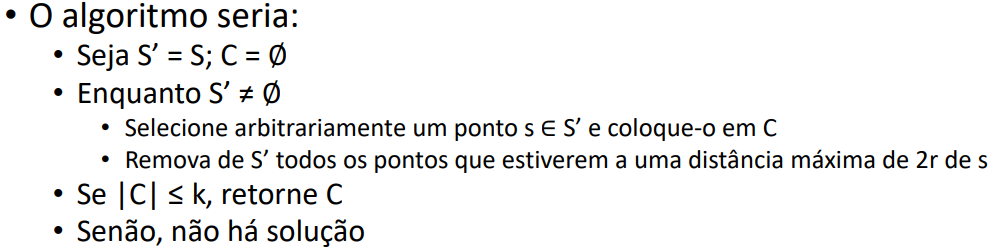


<H2>Definições

In [2]:
def two_approximation(S, k, r, dist_matrix):
    S_copy = S.copy()
    C = []
    while len(S_copy) > 0:
        s = S_copy[np.random.randint(len(S_copy))]
        C.append(s)
        S_copy = [point for point in S_copy if dist_matrix[np.where(S == point)[0][0]][np.where(S == s)[0][0]] > 2 * r]
    if len(C) <= k:
        return C
    else:
        return None

In [3]:
def refining_two_approximation(S, k, limit, dist_matrix):
    dim = 1 if type(S[0]) == int else len(S[0])
    rmax =  np.max([minkowski(S[i], S[j], dim) for i in range(len(S)) for j in range(i+1,len(S))])
    low, high = 0, rmax
    low_v = [low]
    high_v = [high]
    while high - low > limit*rmax:
        mid = (high+low)//2
        C = two_approximation(S, k, mid,dist_matrix)
        if C is not None:
            high = mid -1
        else:
            low = mid + 1
        high_v.append(high)
        low_v.append(low)
    return np.vstack(C), high_v, low_v
    

# 

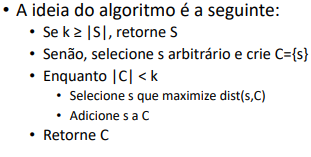

In [4]:
def distance_matrix(points, p=2):
    n = len(points)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist = minkowski(points[i], points[j], p)
            dist_matrix[i][j] = dist
            dist_matrix[j][i] = dist
    
    return dist_matrix

In [33]:
def max_dist_point(dist_matrix, centers_indices):
    max_dist = -1
    max_index = None
    for i in range(len(dist_matrix)):
        if i not in centers_indices:
            min_dist = min(dist_matrix[i][j] for j in centers_indices)
            if min_dist > max_dist:
                max_dist = min_dist
                max_index = i
    return max_index

In [5]:
def k_centers_max_dist(points, k,dist_matrix):
    n = len(points)
    if k >= n:
        return points

    centers_indices = [np.random.choice(n)]

    while len(centers_indices) < k:
        new_center_index = max_dist_point(dist_matrix, centers_indices)
        centers_indices.append(new_center_index)

    centers = [points[i] for i in centers_indices]
    return np.vstack(centers)

<H1> Funções auxiliares de plot

In [6]:
def predict_points(points, centers):
    labels = []
    for p in points:
        dist = list(map(lambda x: minkowski(p,x,p=2),centers))
        idx = dist.index(min(dist))
        labels.append(idx)
    return np.vstack(labels)

In [7]:
def plot_clusters(data, pred_centers, true_centers, duration):
    labels = predict_points(data, pred_centers)
    label_uni = np.reshape(labels, (1,len(labels)))[0]

    colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
                        ),
                        int(max(label_uni) + 1),
                    )
                )
            )
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.7, label='Data', c=colors[label_uni])
    plt.scatter(pred_centers[:, 0], pred_centers[:, 1], color='red', marker='.', s=100, label='Centros Previstos')
    if true_centers is not None:
        plt.scatter(true_centers[:, 0], true_centers[:, 1], color='yellow', marker='.', s=100, label='Centros dos Clusters')
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (duration)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plt.legend()
    plt.show()

Lembrar de Gerar a matriz de distancias antes de rodar

In [8]:
from data_generator_script import generate_synthetic_data, generate_scikit_synthetic_data

In [11]:
results = {}

<H2> 2-Aproximativo Refina Intervalo

<H3> Dado Sintético Scikit

In [ ]:
datasets = generate_scikit_synthetic_data()
k_data = [2, 2, 3, 4, 3, 3, 3, 3, 3]
duration = []
average_time =[]
avg_rand_score = []
avg_silhouette_score = []
for i, (X, y_true) in enumerate(datasets):
     X = StandardScaler().fit_transform(X)
     dist_mat = distance_matrix(X)
     tempo = 0
     rand_scr = 0
     silh_score = 0
     for j in range(30):
          t0 = time.time()
          centers, _,__ =  refining_two_approximation(X, k_data[i], 0.25, dist_mat)
          t1 = time.time()

          y_pred = predict_points(X, centers)
          y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]

          #silh_score += silhouette_score(X, y_pred)
          rand_scr += rand_score(y_true, y_pred) if y_true is not None else 0
          tempo += t1 - t0
           
     average_time.append(tempo/30)
     avg_rand_score.append(rand_scr/30)
     #avg_silhouette_score.append(silh_score/30)
     plot_clusters(X, centers, None, tempo/30)
     print(centers)
     print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")

In [ ]:
results["refined"] = {
    "synthetic_scikit":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

<H3> Dado Sintético Gerado

In [ ]:
k_data = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
datasets = generate_synthetic_data(k_data, 250, [0.5, 2.5, 5])
duration = []
average_time =[]
avg_rand_score = []
avg_silhouette_score = []
for i, (data, true_labels, true_centers) in enumerate(datasets):
      tempo = 0
      rand_scr = 0
      silh_score = 0
      dist_matrix = distance_matrix(data)
      for j in range(30):
            t0 = time.time()
            centers, _,__ =  refining_two_approximation(data, k_data[i], 0.25, dist_matrix)
            t1 = time.time()

            y_pred = predict_points(data, centers)
            y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]

            y_true = predict_points(data, true_centers)
            y_true = np.reshape(y_true, (1,len(y_true)))[0]

            silh_score += silhouette_score(data, y_pred)
            rand_scr += rand_score(y_true, y_pred)

            tempo += t1 - t0
            
      average_time.append(tempo/30)
      avg_rand_score.append(rand_scr/30)
      avg_silhouette_score.append(silh_score/30)
      plot_clusters(data, centers, true_centers, tempo/30)
      print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")

In [ ]:
results["refined"] = {
    "synthetic_generated":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

<H2> 2-Aproximativo Maximiza Distância

<H3> Dado Sintético Scikit

In [34]:
datasets = generate_scikit_synthetic_data()
k_data = [2, 2, 3, 4, 3, 3, 3, 3, 3]
duration = []
metrics = {
    'average_time': [],
    'avg_rand_score': [],
    'avg_silhouette_score': [],

}
for i, (X, y_true) in enumerate(datasets):
     X = StandardScaler().fit_transform(X)
     dist_mat = distance_matrix(X)
     tempo = 0
     rand_scr = 0
     silh_score = 0
     for j in range(30):
          
          t0 = time.time()
          centers =  k_centers_max_dist(X, k_data[i], dist_mat)
          t1 = time.time()
          
          duration = (t1 - t0)
          tempo += t1- t0
          
          y_pred = predict_points(X, centers)
          y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]
          
          silh_score += silhouette_score(X, y_pred)
          rand_scr += rand_score(y_true, y_pred) if y_true is not None else 0
          
     metrics['average_time'].append(round(tempo/30,4))
     metrics['avg_rand_score'].append(round(rand_scr/30,4))
     metrics['avg_silhouette_score'].append(round(silh_score/30,4))
     #plot_clusters(X, centers, None, tempo/30)
     print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")
print(metrics)

AVG Time: 0.0005117416381835938 ------------- AVG Rand Score: 0.5036098864395457 ------------- AVG Silhouette: 0.32695322745741423
AVG Time: 0.0003446817398071289 ------------- AVG Rand Score: 0.681662792251169 ------------- AVG Silhouette: 0.41993456988639494
AVG Time: 0.00088501771291097 ------------- AVG Rand Score: 0.9998220440881764 ------------- AVG Silhouette: 0.8436903836233852
AVG Time: 0.0015970706939697266 ------------- AVG Rand Score: 0.0 ------------- AVG Silhouette: 0.3609416431300947
AVG Time: 0.0010143280029296874 ------------- AVG Rand Score: 0.6666589178356713 ------------- AVG Silhouette: 0.38088690526463004
AVG Time: 0.0010322093963623046 ------------- AVG Rand Score: 0.7836708082832331 ------------- AVG Silhouette: 0.5543973666577544
AVG Time: 0.0010596593221028647 ------------- AVG Rand Score: 0.6958971275885104 ------------- AVG Silhouette: 0.37361109786620383
AVG Time: 0.0009036858876546224 ------------- AVG Rand Score: 0.8169181028724117 ------------- AVG Silho

In [13]:
results["max_dist"] = {
    "synthetic_scikit":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

<H3> Dado Sintético Gerado

In [35]:
k_data = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
datasets = generate_synthetic_data(k_data, 250, [0.5, 2.5, 5])
duration = []
metrics = {
    'average_time': [],
    'avg_rand_score': [],
    'avg_silhouette_score': [],

}
for i, (data, true_labels, true_centers) in enumerate(datasets):
      dist_mat = distance_matrix(data)
      tempo = 0
      silh_score = 0
      rand_scr = 0
      for j in range(30):
            t0 = time.time()
            centers =  k_centers_max_dist(data, k_data[i], dist_mat)
            t1 = time.time()
            duration = (t1 - t0)
            tempo += t1- t0
            y_pred = predict_points(data, centers)
            y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]
            
            y_true = predict_points(data, true_centers)
            y_true = np.reshape(y_true, (1,len(y_true)))[0]
            
            silh_score += silhouette_score(data, y_pred)
            rand_scr += rand_score(y_true, y_pred)
            
      metrics['average_time'].append(round(tempo/30,4))
      metrics['avg_rand_score'].append(round(rand_scr/30,4))
      metrics['avg_silhouette_score'].append(round(silh_score/30,4))
      #plot_clusters(X, centers, None, tempo/30)
      print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")
print(metrics)

AVG Time: 0.00030132929484049477 ------------- AVG Rand Score: 1.0 ------------- AVG Silhouette: 0.9130101472925735
AVG Time: 0.0014939626057942708 ------------- AVG Rand Score: 1.0 ------------- AVG Silhouette: 0.8720277257275341
AVG Time: 0.003417038917541504 ------------- AVG Rand Score: 0.8756876876876876 ------------- AVG Silhouette: 0.6946408661270967
AVG Time: 0.006162365277608235 ------------- AVG Rand Score: 0.8884072804910599 ------------- AVG Silhouette: 0.6374817948180092
AVG Time: 0.010564009348551432 ------------- AVG Rand Score: 0.8873940552961234 ------------- AVG Silhouette: 0.5637714341880772
AVG Time: 0.016509095827738445 ------------- AVG Rand Score: 0.9182822075199433 ------------- AVG Silhouette: 0.5945942155975193
AVG Time: 0.023746959368387856 ------------- AVG Rand Score: 0.9279036851759211 ------------- AVG Silhouette: 0.5439927170053495
AVG Time: 0.034450991948445635 ------------- AVG Rand Score: 0.9151308861551637 ------------- AVG Silhouette: 0.461756833316

In [15]:
results["max_dist"] = {
    "synthetic_generated":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

<H2> KMeans

<H3> Dado Sintético Scikit

In [30]:
datasets = generate_scikit_synthetic_data()
k_data = [2, 2, 3, 4, 3, 3, 3, 3, 3]
duration = []

metrics = {
    'average_time': [],
    'avg_rand_score': [],
    'avg_silhouette_score': [],

}

for i, (X, y_true) in enumerate(datasets):
   X = StandardScaler().fit_transform(X)
   dist_mat = distance_matrix(X)
   tempo = 0
   rand_scr = 0
   silh_score = 0
   for j in range(30):
      t0 = time.time()
      kmeans = KMeans(n_clusters=k_data[i]).fit(X)
      t1 = time.time()
      centers = kmeans.cluster_centers_
      
      y_pred = kmeans.predict(X)
      y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]

      silh_score += silhouette_score(X, y_pred)
      rand_scr += rand_score(y_true, y_pred) if y_true is not None else 0
     
   metrics['average_time'].append(round(tempo/30,4))
   metrics['avg_rand_score'].append(round(rand_scr/30,4))
   metrics['avg_silhouette_score'].append(round(silh_score/30,4))
   #plot_clusters(X, centers, None, tempo/30)   
   print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")
print(metrics)

AVG Time: 0.0 ------------- AVG Rand Score: 0.4990476953907817 ------------- AVG Silhouette: 0.3499712628781716
AVG Time: 0.0 ------------- AVG Rand Score: 0.7268654642618572 ------------- AVG Silhouette: 0.49623476055404186
AVG Time: 0.0 ------------- AVG Rand Score: 1.0 ------------- AVG Silhouette: 0.8438960565792791
AVG Time: 0.0 ------------- AVG Rand Score: 0.0 ------------- AVG Silhouette: 0.413146642583431
AVG Time: 0.0 ------------- AVG Rand Score: 0.8115297261189044 ------------- AVG Silhouette: 0.503193637259508
AVG Time: 0.0 ------------- AVG Rand Score: 0.8828419505678025 ------------- AVG Silhouette: 0.6394416444091249
AVG Time: 0.0 ------------- AVG Rand Score: 0.8635147628590512 ------------- AVG Silhouette: 0.49992549883295134
AVG Time: 0.0 ------------- AVG Rand Score: 0.9463609886439548 ------------- AVG Silhouette: 0.5547764909856423
AVG Time: 0.0 ------------- AVG Rand Score: 0.6045867735470942 ------------- AVG Silhouette: 0.3478900755707423
{'average_time': [0.0,

In [ ]:
for i, (X, y_true) in enumerate(datasets):
   plot_clusters(X, centers, None, tempo/30)

In [17]:
results["kmeans"] = {
    "synthetic_scikit":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

<H3> Dado Sintético Gerado

In [31]:
k_data = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
datasets = generate_synthetic_data(k_data, 250, [0.5, 2.5, 5])
duration = []
metrics = {
    'average_time': [],
    'avg_rand_score': [],
    'avg_silhouette_score': [],

}
for i, (data, true_labels, true_centers) in enumerate(datasets):
      dist_mat = distance_matrix(data)
      tempo = 0
      silh_score = 0
      rand_scr = 0
      for j in range(30):
            t0 = time.time()
            kmeans = KMeans(n_clusters=k_data[i]).fit(data)
            t1 = time.time()
            centers = kmeans.cluster_centers_
            
            y_pred = kmeans.predict(data)
            y_pred = np.reshape(y_pred, (1,len(y_pred)))[0]
            
            y_true = predict_points(data, true_centers)
            y_true = np.reshape(y_true, (1,len(y_true)))[0]
            
            silh_score += silhouette_score(data, y_pred)
            rand_scr += rand_score(y_true, y_pred)
            
            tempo += t1- t0
            
      metrics['average_time'].append(round(tempo/30,4))
      metrics['avg_rand_score'].append(round(rand_scr/30,4))
      metrics['avg_silhouette_score'].append(round(silh_score/30,4))
      #plot_clusters(data, centers, None,0)
      print(f"AVG Time: {tempo/30} ------------- AVG Rand Score: {rand_scr/30} ------------- AVG Silhouette: {silh_score/30}")
print(metrics)

AVG Time: 0.003533307711283366 ------------- AVG Rand Score: 1.0 ------------- AVG Silhouette: 0.9130101472925735
AVG Time: 0.002259532610575358 ------------- AVG Rand Score: 0.9907484349503041 ------------- AVG Silhouette: 0.8602414575223009
AVG Time: 0.001664408047993978 ------------- AVG Rand Score: 1.0 ------------- AVG Silhouette: 0.8860210472641723
AVG Time: 0.0022526979446411133 ------------- AVG Rand Score: 0.9828563437416601 ------------- AVG Silhouette: 0.7657540653880843
AVG Time: 0.003142102559407552 ------------- AVG Rand Score: 0.9628209028241047 ------------- AVG Silhouette: 0.6615959214786913
AVG Time: 0.004233407974243164 ------------- AVG Rand Score: 0.9687889133926872 ------------- AVG Silhouette: 0.7008947794046115
AVG Time: 0.004527926445007324 ------------- AVG Rand Score: 0.9731569284642324 ------------- AVG Silhouette: 0.6432368149224118
AVG Time: 0.004668124516805013 ------------- AVG Rand Score: 0.9710117352568218 ------------- AVG Silhouette: 0.62316180592234

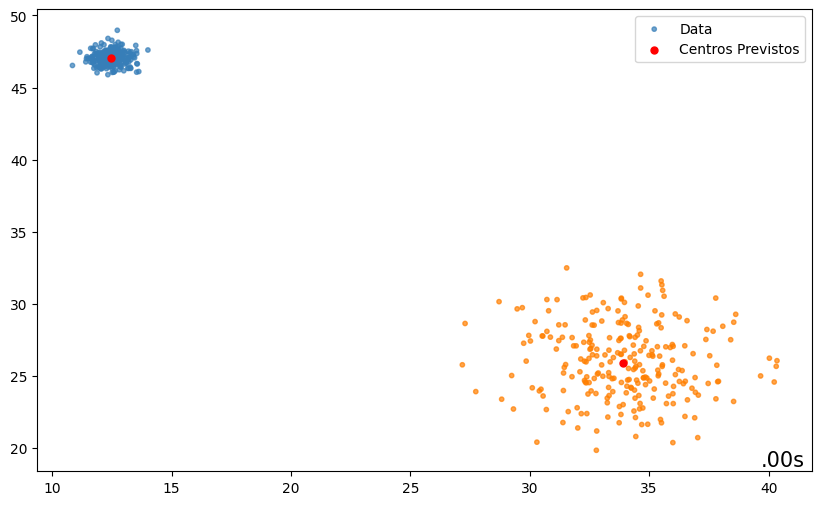

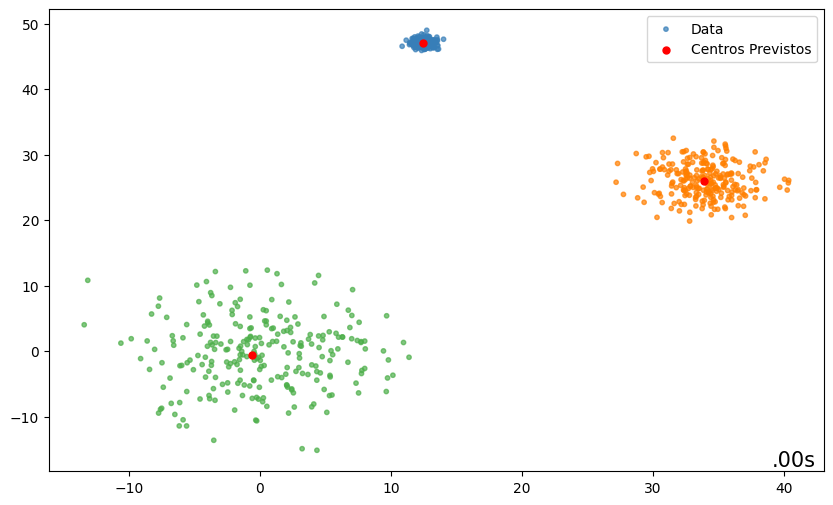

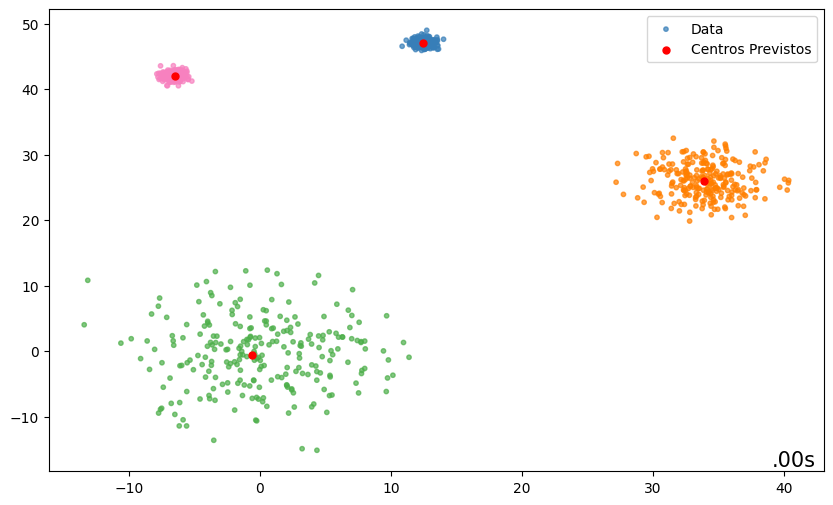

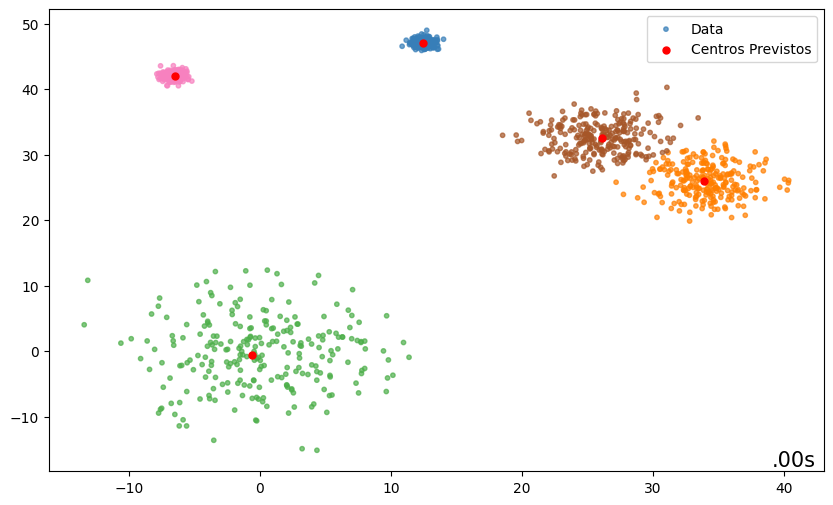

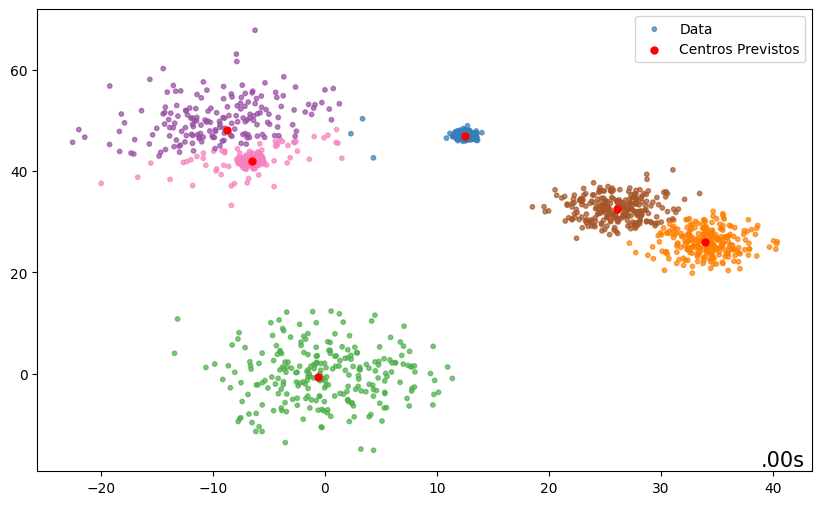

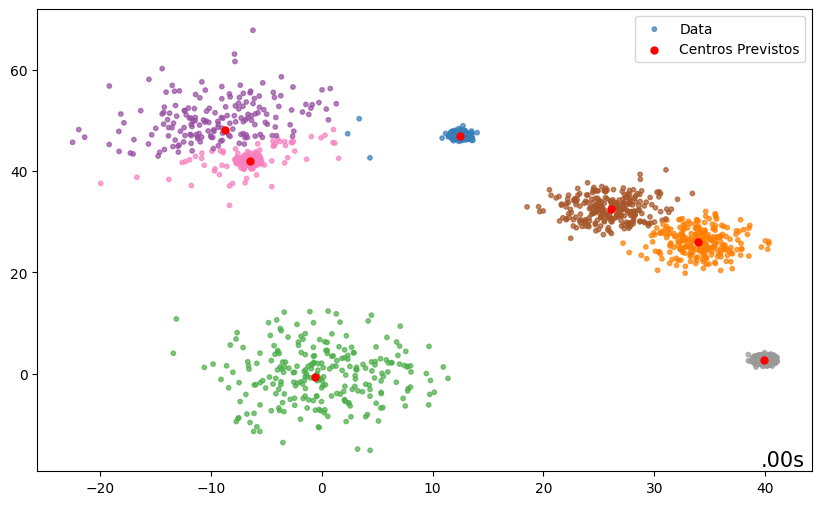

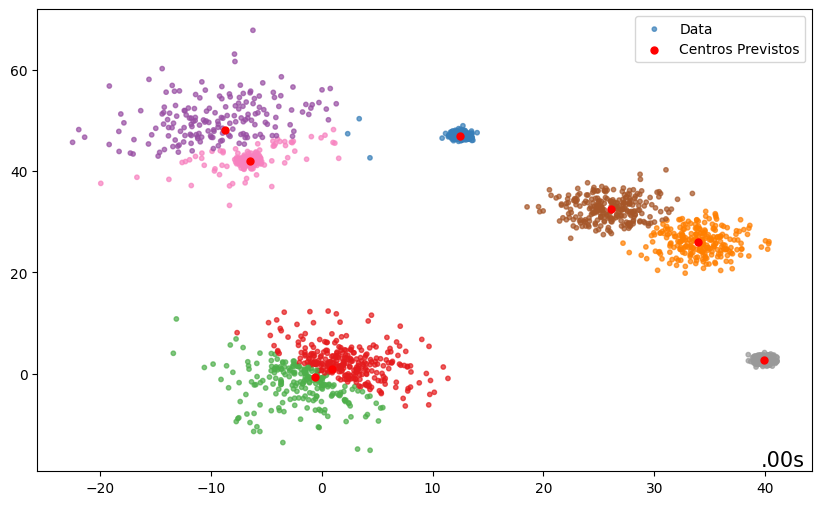

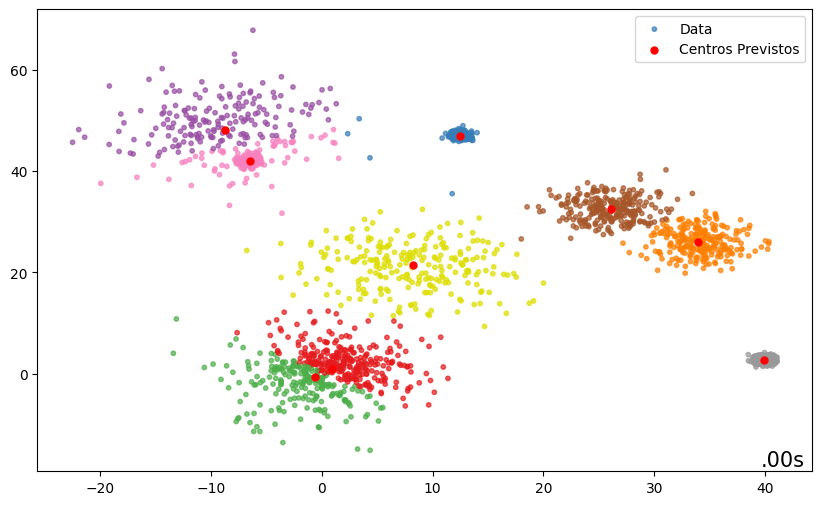

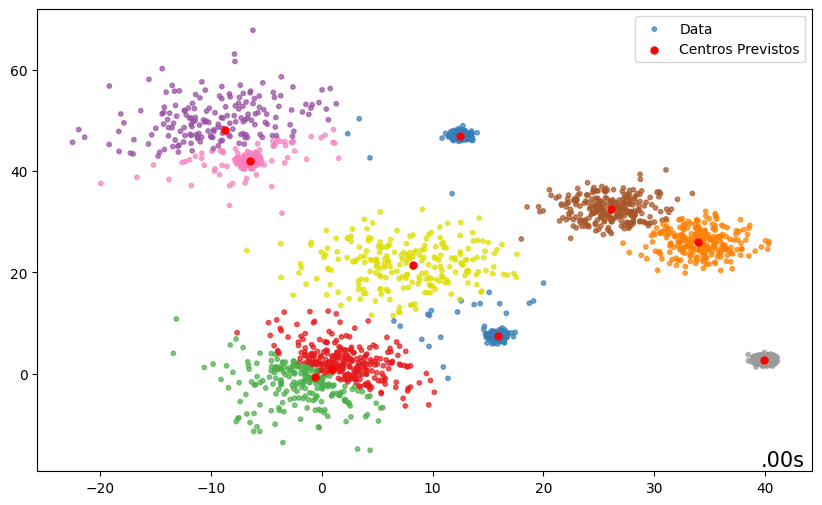

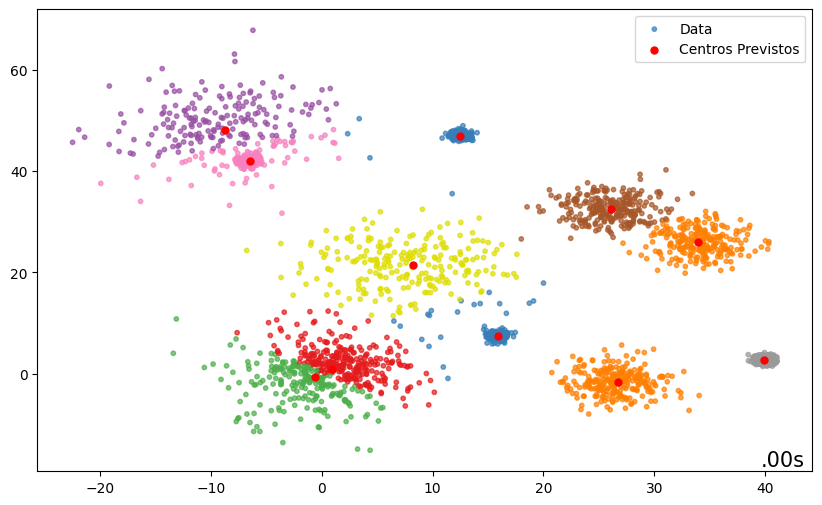

In [21]:
for i, (data, true_labels, true_centers) in enumerate(datasets):
    plot_clusters(data,true_centers,None,0)

In [19]:
results["kmeans"] = {
    "synthetic_generated":{ 
        "time": average_time,
        "rand_score": avg_silhouette_score,
        "silhouette_score": avg_silhouette_score
    }  
}

In [21]:
results

{'max_dist': {'synthetic_generated': {'time': [0.000717933972676595,
    0.0017868677775065105,
    0.0039567708969116214,
    0.008810687065124511,
    0.014865231513977051,
    0.022665055592854817,
    0.03017893632253011,
    0.04044786294301351,
    0.05480164686838786,
    0.08789366881052653],
   'rand_score': [np.float64(0.9130101472925735),
    np.float64(0.8720277257275341),
    np.float64(0.6946408661270967),
    np.float64(0.6374817948180092),
    np.float64(0.5637714341880772),
    np.float64(0.5945942155975193),
    np.float64(0.5439927170053495),
    np.float64(0.46175683331618067),
    np.float64(0.5014765941672635),
    np.float64(0.41363521945412285)],
   'silhouette_score': [np.float64(0.9130101472925735),
    np.float64(0.8720277257275341),
    np.float64(0.6946408661270967),
    np.float64(0.6374817948180092),
    np.float64(0.5637714341880772),
    np.float64(0.5945942155975193),
    np.float64(0.5439927170053495),
    np.float64(0.46175683331618067),
    np.float

In [22]:
#Ainda está orcorrendo erros na execução do algoritmo de refinamento tanto nos dados do scikit quanto nos gerados